In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
from sklearn.datasets import load_digits
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from pytensor_ml.layers import Linear, Input, Sequential
from pytensor_ml.activations import ReLU, LeakyReLU, Softmax
from pytensor_ml.loss import CrossEntropy
from pytensor_ml.model import Model, initialize_weights
from pytensor_ml.optimizers import SGD, ADAGrad, Adam, AdamW

import pytensor

In [3]:
X, y = load_digits(return_X_y=True)
y_onehot = OneHotEncoder().fit_transform(y[:, None]).toarray()
X_normed = MinMaxScaler().fit_transform(X)

In [4]:
# X_in = Input('X_in', shape=(64, ))
X_in = pytensor.tensor.tensor('X_in', shape=(None, 64))

In [5]:
prediction_network = Sequential(
    Linear('Linear_1', n_in=64, n_out=256),
    LeakyReLU(),
    Linear('Linear_2', n_in=256, n_out=128),
    LeakyReLU(),
    Linear('Logits', n_in=128, n_out=10),
)

y_hat = prediction_network(X_in)
model = Model(X_in, y_hat)

loss_fn = CrossEntropy(expect_onehot_labels=True, expect_logits=True, reduction='mean')

In [6]:
print(model)

Add [id A] 'Linear[['?', 128] -> ['?', 10]]'
 ├─ Blockwise{dot, (m,k),(k,n)->(m,n)} [id B]
 │  ├─ Switch [id C] 'LeakyReLU'
 │  │  ├─ Gt [id D]
 │  │  │  ├─ Add [id E] 'Linear[['?', 256] -> ['?', 128]]'
 │  │  │  │  ├─ Blockwise{dot, (m,k),(k,n)->(m,n)} [id F]
 │  │  │  │  │  ├─ Switch [id G] 'LeakyReLU'
 │  │  │  │  │  │  ├─ Gt [id H]
 │  │  │  │  │  │  │  ├─ Add [id I] 'Linear[['?', 64] -> ['?', 256]]'
 │  │  │  │  │  │  │  │  ├─ Blockwise{dot, (m,k),(k,n)->(m,n)} [id J]
 │  │  │  │  │  │  │  │  │  ├─ X_in [id K]
 │  │  │  │  │  │  │  │  │  └─ Linear_1_W [id L]
 │  │  │  │  │  │  │  │  └─ ExpandDims{axis=0} [id M]
 │  │  │  │  │  │  │  │     └─ Linear_1_b [id N]
 │  │  │  │  │  │  │  └─ ExpandDims{axes=[0, 1]} [id O]
 │  │  │  │  │  │  │     └─ 0 [id P]
 │  │  │  │  │  │  ├─ Add [id I] 'Linear[['?', 64] -> ['?', 256]]'
 │  │  │  │  │  │  │  └─ ···
 │  │  │  │  │  │  └─ Mul [id Q]
 │  │  │  │  │  │     ├─ ExpandDims{axes=[0, 1]} [id R]
 │  │  │  │  │  │     │  └─ -0.01 [id S]
 │  │  │

In [7]:
# optim = SGD(model, loss_fn, ndim_out=2, learning_rate=1e-3)
# optim = ADAGrad(model, loss_fn, ndim_out=2, learning_rate=1e-3)
# optim = Adam(model, loss_fn, ndim_out=2, learning_rate=1e-3)
optim = AdamW(model, loss_fn, ndim_out=2, learning_rate=1e-3)

In [8]:
model.initalize_weights()

In [9]:
import numpy as np
n_obs = X.shape[0]
cutpoints = np.arange(0, n_obs, 1000).tolist()
cutpoints += [n_obs]
batch_slices = list(zip(cutpoints[:-1], cutpoints[1:]))
loss_history = []
n_epochs = 100

for _ in range(n_epochs):
    all_idx = np.arange(n_obs)
    np.random.shuffle(all_idx)
    y_epoch = y_onehot[all_idx, :]
    X_epoch = X_normed[all_idx, :]
    for (start, stop) in batch_slices:
        idx = slice(start, stop)
        loss = optim.step(X_epoch[idx], y_epoch[idx])
        loss_history.append(loss)

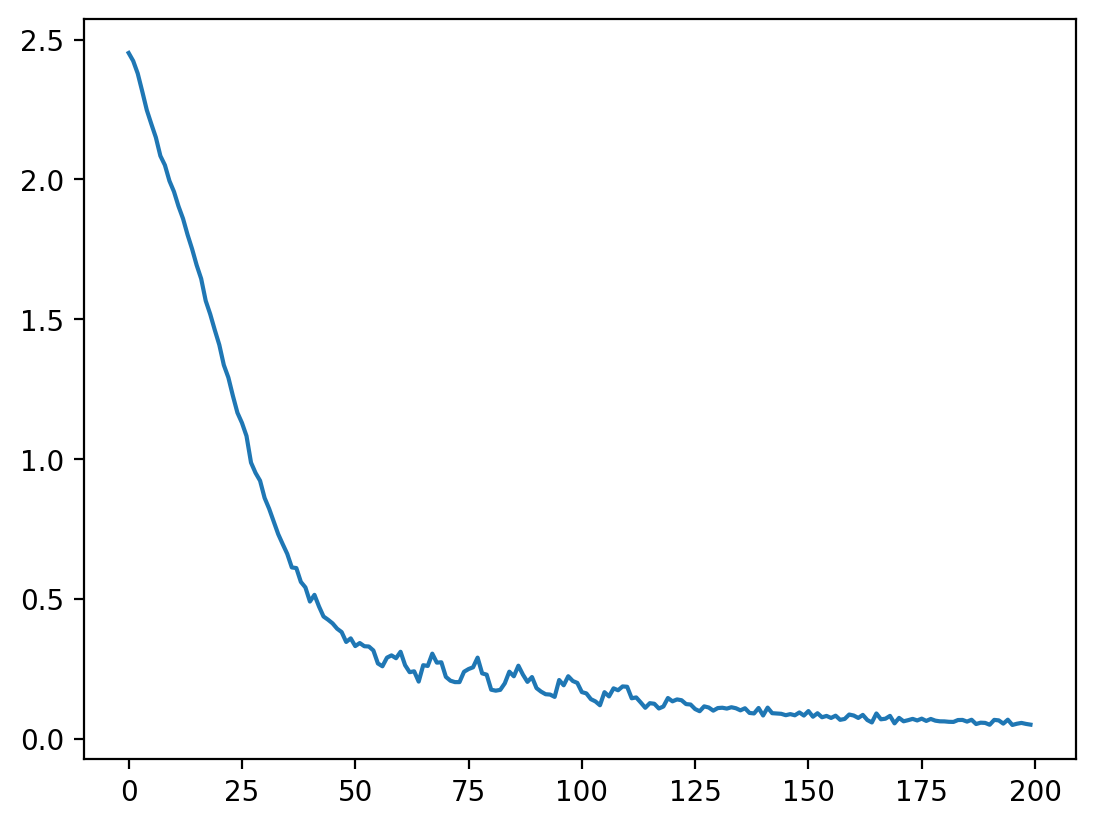

In [10]:
import matplotlib.pyplot as plt
plt.plot(loss_history)

In [11]:
from scipy.special import softmax
y_hat_logits = model.predict(X_normed)
y_hat_probs = softmax(y_hat_logits, axis=-1)
y_hat = np.argmax(y_hat_probs, axis=-1)

<Axes: >

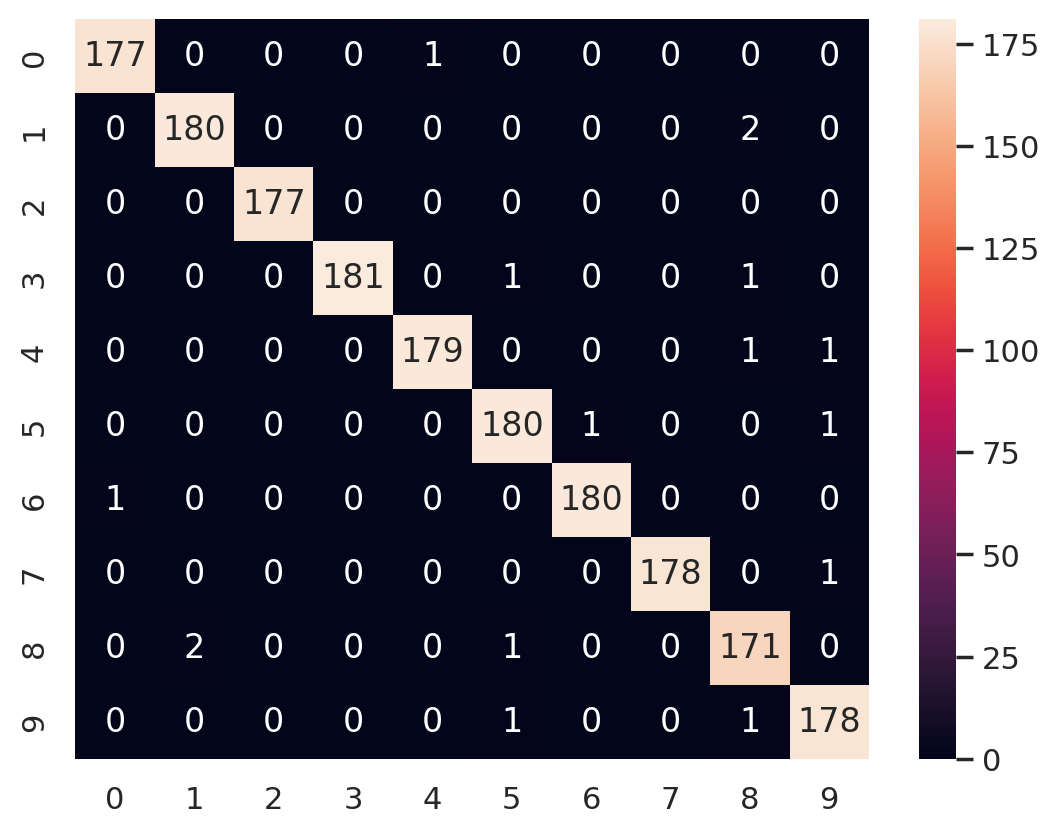

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set_theme()
sns.heatmap(confusion_matrix(y, y_hat), annot=True, fmt='0.0f')